<font color='green'><center><h1> Deep Learning for Pneumonia Detection from Chest X-Ray Images </h1></center>

<font color='purple'><center><h1> Table of Contents </h1></center>

### Table of Contents

* [Import Module](#chapter1)
    * [Import the Libraries](#section_1_1)
    * [Importing the Dataset](section_1_2)
* [Data Visualization and Augmentation](#chapter2)
    * [Data Visualization](#section_2_1)
    * [Data Augmentation](section_2_2)
* [Build the Model - Main](#chapter3) 
* [Evaluate the Model](#chapter4)
    * [Confusion Matrix & Classification Report](#section_4_1)
    * [Plotting Loss and Accuracy](#section_4_2)
* [Hyperparameter Tuning with SGD Optimizer - Model 2](#chapter5)
* [Hyperparameter Tuning with Network Depth - Model 3](#chapter6)
* [Inferences and Comments](#chapter7)

<a class="anchor" id="chapter1"></a>

<font color='purple'><center><h1> Import Module </h1></center>

<font color='blue'><center><h2> Import the Libraries </h2></center>

In [9]:
# importing the packages necessary for this assignment problem

import numpy as np
import pandas as pd
import math
import os
import timeit

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#for checking testing results
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

# Import visualization libraries
from matplotlib import pyplot as plt
plt.rc("font", size=14)
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import AutoLocator, MaxNLocator, LinearLocator, MultipleLocator, FixedLocator, NullLocator

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# and we want to view the charts inline
%matplotlib inline

# Import deep learning libraries
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

TensorFlow version: 2.8.2


<font color='blue'><center><h2> Importing the Dataset </h2></center>

In [10]:
# Mount BITS Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# All the train, test and val folders stored as keys in an array (arr)
arr = next(os.walk('drive/MyDrive/Colab Notebooks/chest_xray'))[1]
arr = arr[2:]

# Create a dictionary using the aforementioned keys to form a dataframe
d = {}
for i in arr:
  d[i] = next(os.walk('drive/MyDrive/Colab Notebooks/chest_xray/chest_xray/'+i))[1]

for i in arr:
    target = []
    images = []
    for j in d[i]:
        files = next(os.walk('drive/MyDrive/Colab Notebooks/chest_xray/chest_xray/'+i+'/'+j))[2]
        images += files
        target += [j]*len(files)
    
    d[i] = pd.DataFrame({'images':np.array(images).flatten(),'target':np.array(target).flatten()})
       
# Appending absolute paths to the image url
for i in arr:
    d[i]['image_paths'] =  'drive/MyDrive/Colab Notebooks/chest_xray/chest_xray/'+ i + '/' + d[i]['target'] + '/' + d[i]['images']
    
train = d['train']
val = d['val']
test = d['test']

# Display the dataframe
train

,images,target,image_paths
0,person549_bacteria_2303.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
1,person533_virus_1055.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
2,person491_bacteria_2081.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
3,person504_bacteria_2127.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
4,person548_bacteria_2297.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
...,...,...,...
5213,IM-0512-0001.jpeg,NORMAL,drive/MyDrive/Colab Notebooks/chest_xray/chest...
5214,IM-0523-0001-0001.jpeg,NORMAL,drive/MyDrive/Colab Notebooks/chest_xray/chest...
5215,IM-0524-0001.jpeg,NORMAL,drive/MyDrive/Colab Notebooks/chest_xray/chest...
5216,IM-0531-0001-0001.jpeg,NORMAL,drive/MyDrive/Colab Notebooks/chest_xray/chest...


In [12]:
# Shuffling the dataframe
train = train.sample(frac=1).reset_index()
train = train.drop(['index'],axis=1)
train

,images,target,image_paths
0,person1814_bacteria_4669.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
1,person359_bacteria_1646.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
2,person420_bacteria_1847.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
3,IM-0555-0001.jpeg,NORMAL,drive/MyDrive/Colab Notebooks/chest_xray/chest...
4,person1122_virus_1847.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
...,...,...,...
5213,person294_virus_611.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
5214,person827_bacteria_2738.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
5215,person1433_virus_2447.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...
5216,person279_bacteria_1315.jpeg,PNEUMONIA,drive/MyDrive/Colab Notebooks/chest_xray/chest...


<font color='purple'><center><h1> Data Visualization and Augmentation </h1></center>

<font color='blue'><center><h2> Data Visualization </h2></center>

target: NORMAL


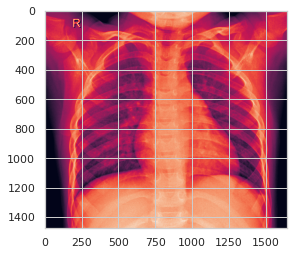

In [14]:
# Display Normal image
img_normal = plt.imread(train['image_paths'][3])
plt.imshow(img_normal)
print('target:' ,train['target'][3])

target: PNEUMONIA


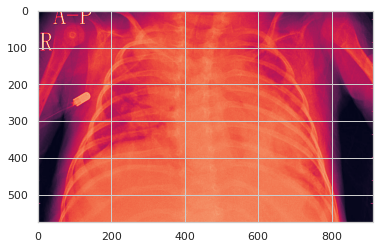

In [15]:
# Display Pneumonia image
img_pneumonia = plt.imread(train['image_paths'][0])
plt.imshow(img_pneumonia)

print('target:' ,train['target'][0])

<font color='blue'><center><h2> Data Augmentation </h2></center>

In [16]:
IMG_SIZE = 64
BATCH = 16
SEED = 42

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255., zoom_range = 0.1, rotation_range = 0.1,
                                                                width_shift_range = 0.1, height_shift_range = 0.1)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [17]:
#directory=train_path, #dataframe contains the full paths

ds_train = train_datagen.flow_from_dataframe(train, x_col = 'image_paths', y_col = 'target', target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary', batch_size = BATCH, seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val, x_col = 'image_paths', y_col = 'target', target_size = (IMG_SIZE, IMG_SIZE),
                                         class_mode = 'binary', batch_size = BATCH, seed = SEED)

ds_test = test_datagen.flow_from_dataframe(test, x_col = 'image_paths', y_col = 'target', target_size = (IMG_SIZE, IMG_SIZE),
                                          class_mode = 'binary', batch_size = BATCH, shuffle = False)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="image_paths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


<font color='purple'><center><h1> Build the Model - Main </h1></center>

In [37]:
model = tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 1
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 2
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 3
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 4 - Flattening
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Output Layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Print Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

In [38]:
### CallBacks
count = 0

### Save the best model
saved_callbacks = tf.keras.callbacks.ModelCheckpoint('./saved_models/bestmodel_'+str(count), 
                                                     save_weights_only=False, monitor='val_loss', save_best_only=True)
    
### Compile and Fit Model 
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy',])  

history = model.fit(ds_train, validation_data = ds_val, epochs=12, verbose=2, callbacks=[saved_callbacks])

Epoch 1/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 1015s - loss: 0.4373 - accuracy: 0.8029 - val_loss: 0.5706 - val_accuracy: 0.7500 - 1015s/epoch - 3s/step
Epoch 2/12
326/326 - 86s - loss: 0.2020 - accuracy: 0.9191 - val_loss: 0.8160 - val_accuracy: 0.6250 - 86s/epoch - 263ms/step
Epoch 3/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 88s - loss: 0.1723 - accuracy: 0.9369 - val_loss: 0.4881 - val_accuracy: 0.8750 - 88s/epoch - 269ms/step
Epoch 4/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 89s - loss: 0.1452 - accuracy: 0.9429 - val_loss: 0.3954 - val_accuracy: 0.8125 - 89s/epoch - 274ms/step
Epoch 5/12
326/326 - 86s - loss: 0.1386 - accuracy: 0.9440 - val_loss: 0.4305 - val_accuracy: 0.8125 - 86s/epoch - 264ms/step
Epoch 6/12
326/326 - 88s - loss: 0.1180 - accuracy: 0.9572 - val_loss: 0.6775 - val_accuracy: 0.6875 - 88s/epoch - 270ms/step
Epoch 7/12
326/326 - 88s - loss: 0.1

<font color='purple'><center><h1> Evaluate the Model </h1></center>

In [39]:
model = tf.keras.models.load_model('./saved_models/bestmodel_'+str(count))
model.evaluate(ds_test)

39/39 [==============================] - 115s 3s/step - loss: 0.3108 - accuracy: 0.8958


[0.3108167052268982, 0.8958333134651184]

<font color='blue'><center><h2> Confusion Matrix & Classification Report </h2></center>

In [40]:
#Confusion Matrix and Classification Report
Y_pred = model.predict(ds_test, 39)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(ds_test.classes, y_pred))
print('Classification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(ds_test.classes, y_pred, target_names=target_names))

Confusion Matrix
[[234   0]
 [390   0]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
   Pneumonia       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<font color='blue'><center><h2> Plotting Loss and Accuracy </h2></center>

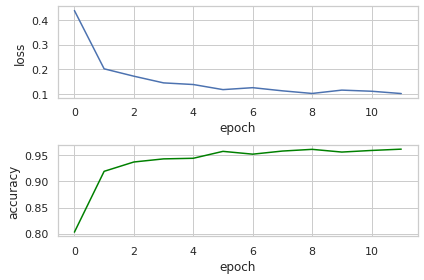

In [41]:
plt.subplot(2 ,1, 1)
a = plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(2, 1 ,2)
b = plt.plot(history.history['accuracy'],color="green")
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()

<font color='purple'><center><h1> Hyperparameter Tuning with SGD Optimizer - Model 2 </h1></center>

In [42]:
model_2 = tf.keras.Sequential()

# Input layer
model_2.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
model_2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 1
model_2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model_2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 2
model_2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model_2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 3
model_2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model_2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 4 - Flattening
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Output Layer
model_2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Print Model Summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 64)        

In [43]:
### CallBacks
count = 0

### Save the best model
saved_callbacks = tf.keras.callbacks.ModelCheckpoint('./saved_models/bestmodel_'+str(count), 
                  save_weights_only=False, monitor='val_loss', save_best_only=True)
    
### Compile and Fit Model 
model_2.compile(optimizer = tf.keras.optimizers.SGD(), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy',])  

history_2 = model_2.fit(ds_train, validation_data = ds_val, epochs=12, verbose=2, callbacks=[saved_callbacks])

Epoch 1/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 91s - loss: 0.5813 - accuracy: 0.7421 - val_loss: 0.7957 - val_accuracy: 0.5000 - 91s/epoch - 280ms/step
Epoch 2/12
326/326 - 88s - loss: 0.5558 - accuracy: 0.7429 - val_loss: 0.7961 - val_accuracy: 0.5000 - 88s/epoch - 270ms/step
Epoch 3/12
326/326 - 90s - loss: 0.5014 - accuracy: 0.7590 - val_loss: 0.8956 - val_accuracy: 0.5625 - 90s/epoch - 276ms/step
Epoch 4/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 89s - loss: 0.4146 - accuracy: 0.8066 - val_loss: 0.5913 - val_accuracy: 0.6875 - 89s/epoch - 274ms/step
Epoch 5/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 90s - loss: 0.3224 - accuracy: 0.8589 - val_loss: 0.4584 - val_accuracy: 0.8125 - 90s/epoch - 276ms/step
Epoch 6/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 91s - loss: 0.2773 - accuracy: 0.8854 - val_loss: 0.3833 - val_accuracy: 

In [44]:
model_2 = tf.keras.models.load_model('./saved_models/bestmodel_'+str(count))
model_2.evaluate(ds_test)

39/39 [==============================] - 8s 211ms/step - loss: 0.3778 - accuracy: 0.8157


[0.3778236210346222, 0.8157051205635071]

In [45]:
#Confusion Matrix and Classification Report
Y_pred_2 = model_2.predict_generator(ds_test, 40)
y_pred_2 = np.argmax(Y_pred_2, axis=1)
print('Confusion Matrix')
print(confusion_matrix(ds_test.classes, y_pred_2))
print('Classification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(ds_test.classes, y_pred_2, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[234   0]
 [390   0]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
   Pneumonia       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<font color='purple'><center><h1> Hyperparameter Tuning with Network Depth - Model 3 </h1></center>

---



In [46]:
model_3 = tf.keras.Sequential()

# Input layer
model_3.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
model_3.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 1
model_3.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model_3.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 2
model_3.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model_3.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Hidden Layer 3 - Flattening
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Output Layer
model_3.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Print Model Summary
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)        

In [47]:
### CallBacks
count = 0

### Save the best model
saved_callbacks = tf.keras.callbacks.ModelCheckpoint('./saved_models/bestmodel_'+str(count), 
                  save_weights_only=False, monitor='val_loss', save_best_only=True)
    
### Compile and Fit Model 
model_3.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy',])  

history_3 = model_3.fit(ds_train, validation_data = ds_val, epochs=12, verbose=2, callbacks=[saved_callbacks])

Epoch 1/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 91s - loss: 0.4191 - accuracy: 0.8129 - val_loss: 0.3850 - val_accuracy: 0.8125 - 91s/epoch - 280ms/step
Epoch 2/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 88s - loss: 0.2493 - accuracy: 0.8984 - val_loss: 0.3273 - val_accuracy: 0.8125 - 88s/epoch - 270ms/step
Epoch 3/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 88s - loss: 0.1883 - accuracy: 0.9287 - val_loss: 0.3138 - val_accuracy: 0.8750 - 88s/epoch - 271ms/step
Epoch 4/12
INFO:tensorflow:Assets written to: ./saved_models/bestmodel_0/assets
326/326 - 88s - loss: 0.1780 - accuracy: 0.9302 - val_loss: 0.2996 - val_accuracy: 0.9375 - 88s/epoch - 271ms/step
Epoch 5/12
326/326 - 89s - loss: 0.1569 - accuracy: 0.9396 - val_loss: 0.3946 - val_accuracy: 0.8750 - 89s/epoch - 273ms/step
Epoch 6/12
326/326 - 88s - loss: 0.1425 - accuracy: 0.9484 - val_loss: 0.3055 - val_accuracy: 

In [48]:
model_3 = tf.keras.models.load_model('./saved_models/bestmodel_'+str(count))
model_3.evaluate(ds_test)

39/39 [==============================] - 9s 217ms/step - loss: 0.4252 - accuracy: 0.8670


[0.4252314567565918, 0.8669871687889099]

In [50]:
#Confusion Matrix and Classification Report
Y_pred_3 = model_3.predict_generator(ds_test, 40)
y_pred_3 = np.argmax(Y_pred_3, axis=1)
print('Confusion Matrix')
print(confusion_matrix(ds_test.classes, y_pred_3))
print('Classification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(ds_test.classes, y_pred_3, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[234   0]
 [390   0]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
   Pneumonia       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<font color='purple'><center><h1> Inferences and Comments </h1></center>


<font color='green'> <b> Explanations </b> <br><br>
<i> <ul style="list-style-type:disc"> 
<li> The results of the Adam optimizer are generally better than every other optimization algorithms, have faster computation time, and require fewer parameters for tuning. Because of all that, Adam is recommended as the default optimizer for most of the applications. </li><br>
<li> The main model that used Adam optimizer and 4 hidden layers gave ~90% accuracy whereas the other 2 models gave a lower accuracy. The model that used SGD and 4 hidden layers gave ~82% accuracy. The model that used Adam optimizer and 3 hidden layers gave ~87% accuracy.</li><br>

